# F1 Tire Degradation Model

### Joshua Yu

For this project, I am attempting to model tire degradation in F1 races based off of data from the currently running 2025 season, with the goal of finding the optimal pit stop strategy both in terms of when to pit and what tires to use.

### Why are tires important?

Tires play a critical role in race strategy, as drivers want to maximize speed while minimizing tire degradation. Different tire compounds have different lifespans, as softer compounds are faster due to better grip, but also wear down faster due to the heat and friction from the track.

Therefore, choosing which tires to use and when to swap tires is pivotal for achieving the fastest time possible.

The data for this project was obtained from Tracing Insights, which compiles publicly available data released by F1.

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [45]:
br = pd.read_csv("https://raw.githubusercontent.com/kururyn/ML-Project/refs/heads/main/2025-Bahrain%20Grand%20Prix-Race.csv")
bw = pd.read_csv("https://raw.githubusercontent.com/kururyn/ML-Project/refs/heads/main/2025-Bahrain%20Grand%20Prix-Race-weather.csv")
jr = pd.read_csv("https://raw.githubusercontent.com/kururyn/ML-Project/refs/heads/main/2025-Japanese%20Grand%20Prix-Race.csv")
jw = pd.read_csv("https://raw.githubusercontent.com/kururyn/ML-Project/refs/heads/main/2025-Japanese%20Grand%20Prix-Race-weather.csv")
cr = pd.read_csv("https://raw.githubusercontent.com/kururyn/ML-Project/refs/heads/main/2025-Chinese%20Grand%20Prix-Race.csv")
cw = pd.read_csv("https://raw.githubusercontent.com/kururyn/ML-Project/refs/heads/main/2025-Chinese%20Grand%20Prix-Race-weather.csv")
ar = pd.read_csv("https://raw.githubusercontent.com/kururyn/ML-Project/refs/heads/main/2025-Australian%20Grand%20Prix-Race.csv")
aw = pd.read_csv("https://raw.githubusercontent.com/kururyn/ML-Project/refs/heads/main/2025-Australian%20Grand%20Prix-Race-weather.csv")

# Data Cleaning and Visualization

There are some key factors that must be accounted for. 

First, cars need to carry fuel, and fuel is heavy. Heavy cars travel at slower speeds, and this would affect lap times. For the sake of simplicity, it is assumed all cars start with 110 kg of fuel, the maximum allowed, and finish the race with 0 kg of fuel, all while burning fuel at a constant rate.

As such, this allows for the fuel weight of the car on each lap to be calculated, and testing done by outside parties has concluded that each kg of fuel is approximately equivalent to a lap time loss of 0.03s. This allows for the calculation of fuel-adjusted lap times.

In addition, every car's lap 1 will be removed as they start from different positions on the grid, and thus need to travel a different distance in order to finish the first lap.

In [46]:
br = br[br['LapNumber'] != 1]
jr = jr[jr['LapNumber'] != 1]
cr = cr[cr['LapNumber'] != 1]
ar = ar[ar['LapNumber'] != 1]

In [47]:
def calculate_fuel_adjusted_time(df, total_laps):
   fuel_per_lap = 110 / total_laps
   df['FuelWeight'] = (total_laps - df['LapNumber']) * fuel_per_lap
   df['LapTime_fuel_adjusted'] = df['LapTime_in_seconds'] - (df['FuelWeight'] * 0.03)
   return df

br = calculate_fuel_adjusted_time(br, 57)
jr = calculate_fuel_adjusted_time(jr, 53)
cr = calculate_fuel_adjusted_time(cr, 56)
ar = calculate_fuel_adjusted_time(ar, 57)

In [48]:
print("BR DataFrame - Bahrain (57 laps):")
print(br[['LapNumber', 'LapTime_in_seconds', 'FuelWeight', 'LapTime_fuel_adjusted']].head(4))

print("\nJR DataFrame - Japan (53 laps):")
print(jr[['LapNumber', 'LapTime_in_seconds', 'FuelWeight', 'LapTime_fuel_adjusted']].head(4))

print("\nCR DataFrame - China (56 laps):")
print(cr[['LapNumber', 'LapTime_in_seconds', 'FuelWeight', 'LapTime_fuel_adjusted']].head(4))

print("\nAR DataFrame - Australia (57 laps):")
print(ar[['LapNumber', 'LapTime_in_seconds', 'FuelWeight', 'LapTime_fuel_adjusted']].head(4))

BR DataFrame - Bahrain (57 laps):
   LapNumber  LapTime_in_seconds  FuelWeight  LapTime_fuel_adjusted
1        2.0              97.492  106.140351              94.307789
2        3.0              98.083  104.210526              94.956684
3        4.0              98.133  102.280702              95.064579
4        5.0              98.043  100.350877              95.032474

JR DataFrame - Japan (53 laps):
   LapNumber  LapTime_in_seconds  FuelWeight  LapTime_fuel_adjusted
1        2.0              93.943  105.849057              90.767528
2        3.0              93.639  103.773585              90.525792
3        4.0              93.744  101.698113              90.693057
4        5.0              93.776   99.622642              90.787321

CR DataFrame - China (56 laps):
   LapNumber  LapTime_in_seconds  FuelWeight  LapTime_fuel_adjusted
1        2.0              97.551  106.071429              94.368857
2        3.0              97.689  104.107143              94.565786
3        4.0    

During the race, drivers may make mistakes, suffer from lock up, spin out, or run into other obstacles that may impede their driving. As such, only the lap times within 3% of the fastest lap are being kept, in order to remove potential outliers. As Australia was a rainy race, this percentage will be increased to 15% to account for the larger range of lap times due to changing track conditions.

In [49]:
def filter_lap_times_within_3_percent(df):
   fastest_lap = df['LapTime_fuel_adjusted'].min()
   threshold = fastest_lap * 1.03
   return df[df['LapTime_fuel_adjusted'] <= threshold]

def filter_lap_times_within_15_percent(df):
   fastest_lap = df['LapTime_fuel_adjusted'].min()
   threshold = fastest_lap * 1.15
   return df[df['LapTime_fuel_adjusted'] <= threshold]

brf = filter_lap_times_within_3_percent(br)
jrf = filter_lap_times_within_3_percent(jr)
crf = filter_lap_times_within_3_percent(cr)
arf = filter_lap_times_within_15_percent(ar)

print(f"Bahrain: {len(brf)} out of {len(br)} laps within 3% of fastest")
print(f"Japan: {len(jrf)} out of {len(jr)} laps within 3% of fastest")
print(f"China: {len(crf)} out of {len(cr)} laps within 3% of fastest")
print(f"Australia: {len(arf)} out of {len(ar)} laps within 15% of fastest")

Bahrain: 464 out of 1108 laps within 3% of fastest
Japan: 948 out of 1039 laps within 3% of fastest
China: 887 out of 1045 laps within 3% of fastest
Australia: 527 out of 907 laps within 15% of fastest


We also want to remove the laps that were driven on tires that had been previously used, i.e. tires that are not fresh. This happens because teams are only allotted 13 sets of tires for the entire race weekend, and they may have had to use extra pairs of tires in order to achieve a better qualifying result. 

These teams would then start on older tires and pit earlier in the race to try and undercut their opponents, a strategy where you push the car after a pit stop in order to come out ahead of your opponent when they decide to pit.

However, the lap times on older tires would be slower, so they must be removed in order to keep the model consistent.

In [50]:
brf = brf[brf["FreshTyre"] == True]
jrf = jrf[jrf["FreshTyre"] == True]
crf = crf[crf["FreshTyre"] == True]
arf = arf[arf["FreshTyre"] == True]

In [51]:
def plot_tire_degradation_by_compound(df, title_prefix):
    compounds = df["Compound"].unique()
    colors = plt.cm.tab10.colors

    # Standardize axes
    x_min = df["TyreLife"].min()
    x_max = df["TyreLife"].max()
    y_min = df["LapTime_fuel_adjusted"].min()
    y_max = df["LapTime_fuel_adjusted"].max()

    plt.figure(figsize=(15, 6))

    for i, compound in enumerate(compounds):
        subset = df[df["Compound"] == compound]
        x = subset["TyreLife"]
        y = subset["LapTime_fuel_adjusted"]

        plt.subplot(1, len(compounds), i + 1)
        plt.scatter(x, y, label=compound, color=colors[i % len(colors)], alpha=0.6)

        plt.xlabel("Tire Life")
        plt.ylabel("Lap Adjusted Time")
        plt.title(f"{title_prefix}: {compound}")
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.tight_layout()

    plt.show()

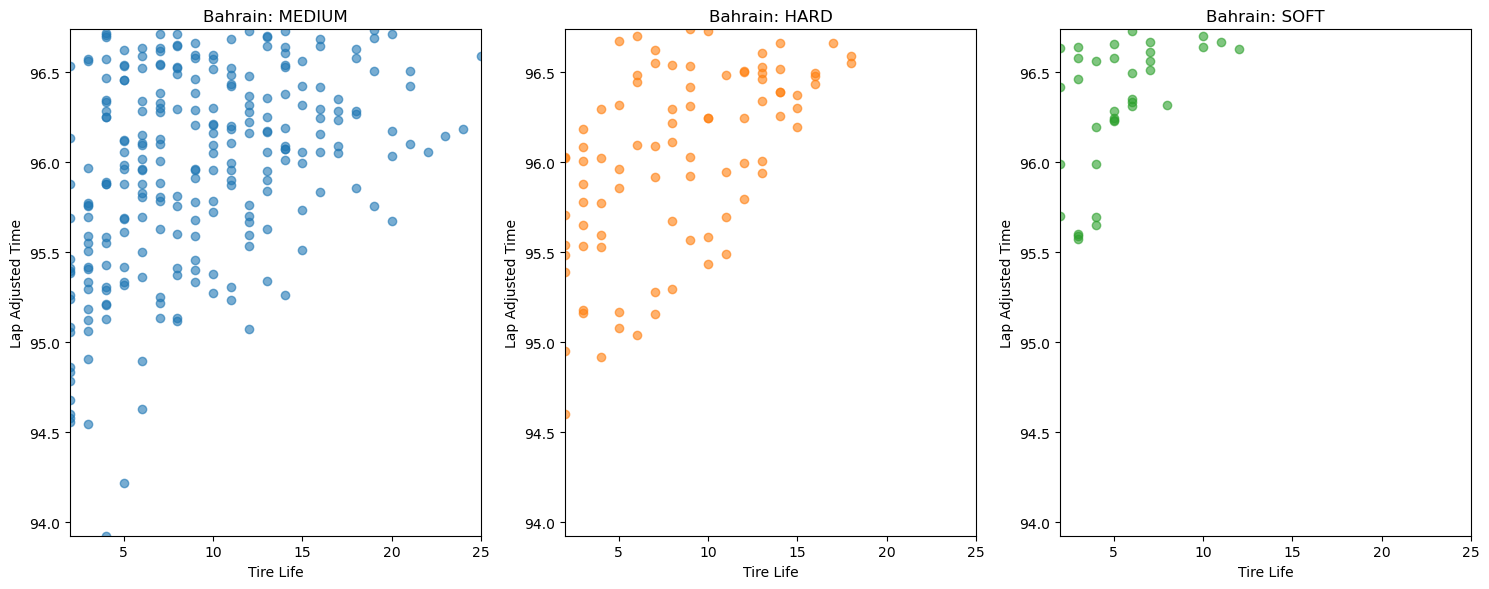

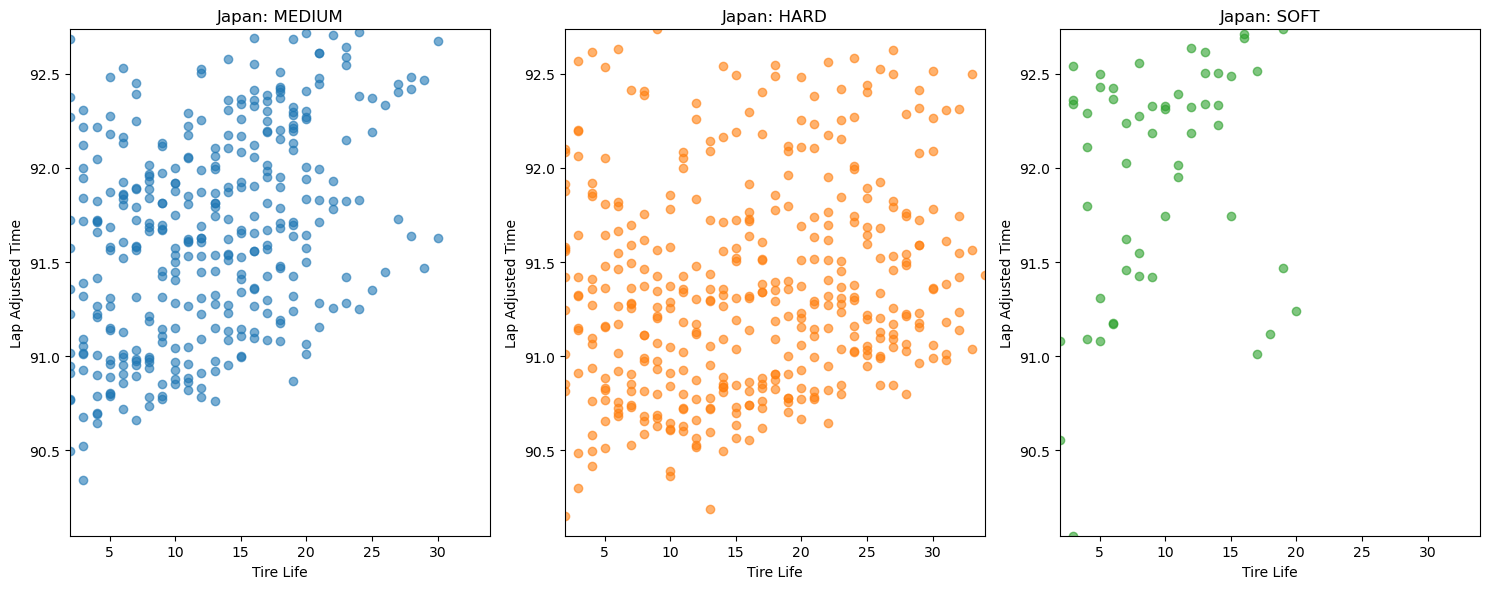

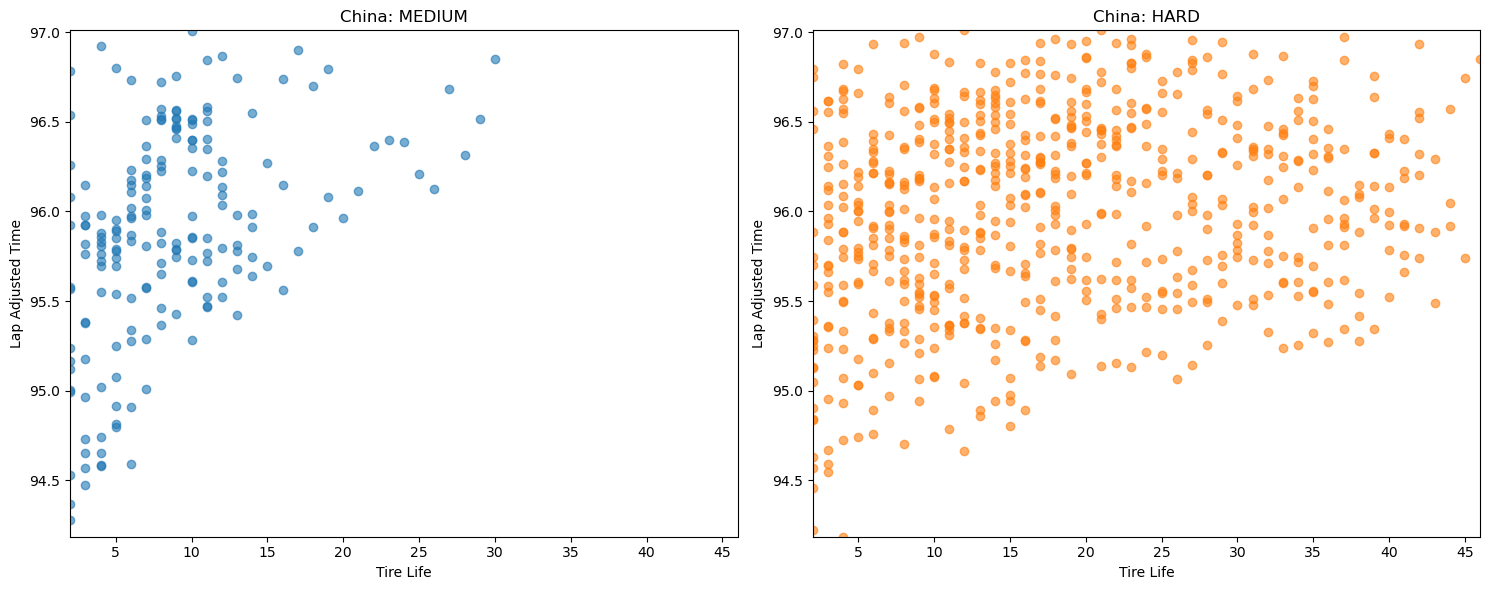

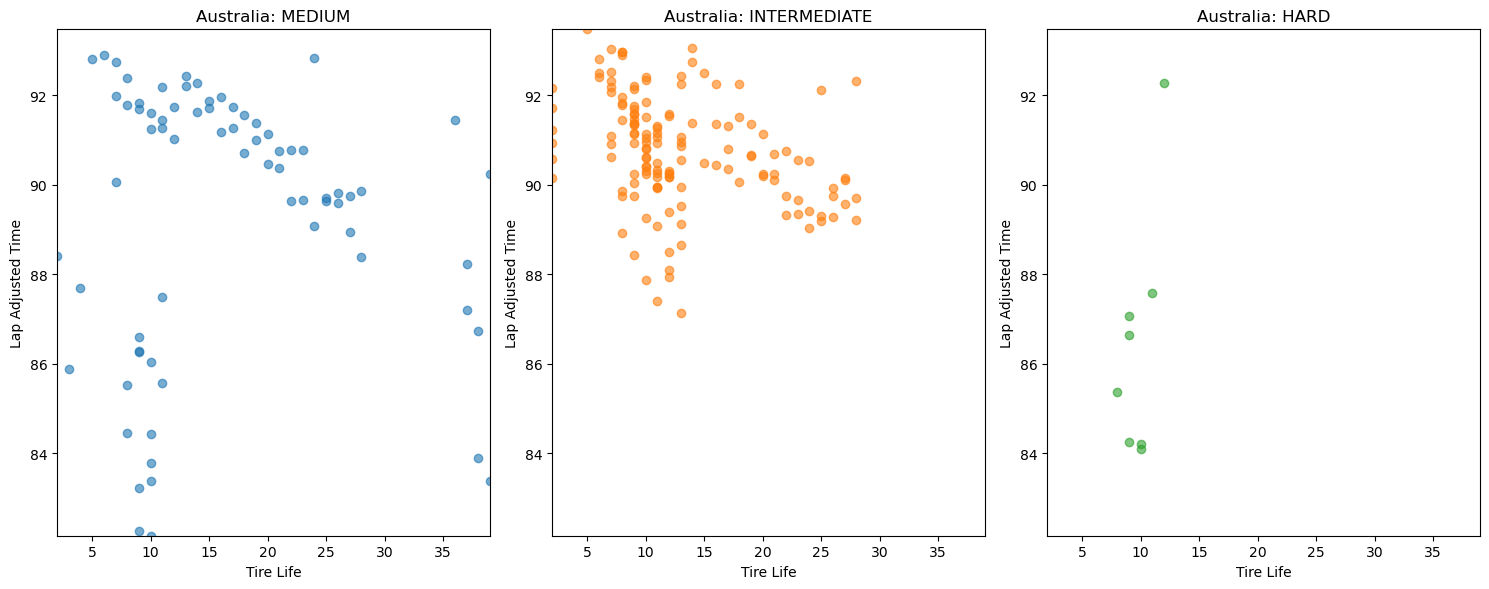

In [52]:
plot_tire_degradation_by_compound(brf, "Bahrain")
plot_tire_degradation_by_compound(jrf, "Japan")
plot_tire_degradation_by_compound(crf, "China")
plot_tire_degradation_by_compound(arf, "Australia")

Unfortunately, it seems like the data from the Australian GP was just not particularly telling, as drivers were unable to find consistent lap times in the rain. As such, only the other three races will be used from this point onwards.

In addition, this data can also illustrate the type of track driven on and climate that each race occurred in.

Bahrain had extremely high temperatures, so tire degradation was more significant, as hot tires are softer and thus wear down more quickly. 

On the other hand, Japan and China had cooler temperatures and were held on recently re-paved track, meaning tire degradation was a lot less meaningful. In addition, the Japanese Grand Prix is notorious for high speed corners and an absence of sharp braking zones, further exacerbating the lack of tire degradation.


During the race, drivers need to make pit stops in order to change tires. This would slow down the cars, as drivers need obey pit lane speed limits and come to a stop while the pit stop is being performed. The average pit stop duration for each race will need to be calculated, since the length of the pits is not uniform across all races.

In [53]:
def compute_average_pit_stop_duration(df):
    # Convert columns to Timedelta (only if they’re not already)
    df = df.copy()
    df["PitInTime"] = pd.to_timedelta(df["PitInTime"], errors="coerce")
    df["PitOutTime"] = pd.to_timedelta(df["PitOutTime"], errors="coerce")

    durations = []

    for i in range(len(df) - 1):
        pit_in = df.iloc[i]["PitInTime"]
        pit_out = df.iloc[i + 1]["PitOutTime"]

        if pd.notna(pit_in) and pd.notna(pit_out):
            duration = (pit_out - pit_in).total_seconds()
            if duration > 0:
                durations.append(duration)

    return sum(durations) / len(durations) if durations else None


# Compute for each race
br_avg = compute_average_pit_stop_duration(br)
jr_avg = compute_average_pit_stop_duration(jr)
cr_avg = compute_average_pit_stop_duration(cr)

print(f"Bahrain average pit stop duration: {br_avg:.2f} seconds")
print(f"Japan average pit stop duration: {jr_avg:.2f} seconds")
print(f"China average pit stop duration: {cr_avg:.2f} seconds")


Bahrain average pit stop duration: 25.27 seconds
Japan average pit stop duration: 23.81 seconds
China average pit stop duration: 23.35 seconds


# Tire Degradation Model and Race Simulation

A MLP will now be used in order to identify the relationship between tire compound, tire life, and lap time; this relationship will be used to simulate entire races and figure out optimal pit strategy.

In particular, a combination of linear and ReLU layers is being used for modeling tire degradation, and then the race simulation is done through iteration.

The race simulation starts by testing each race with 0 pit stops on each tire compound, and then checks 1, 2, and 3 pit stops, as any more would definitely not be beneficial as seen from real life races. In addition, in order to speed up the calculation time, the simulation starts testing pit stops at conventionally common times (when do actual cars normally pit), and then adjusts to check later and earlier pit stops.

In [54]:
import torch
from typing import List, Tuple, Dict

class F1LapTimePredictor:
    """Model to predict lap times based on tire life and compound"""
    
    def __init__(self):
        """Initialize the lap time predictor"""
        self.lap_time_models = {}
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.compounds = None
        self.data = None
        
    def train(self, df):
        """
        Train models to predict lap time based on tire life for each compound.
        
        Args:
            df: DataFrame containing race data with LapTime_fuel_adjusted, TyreLife, and Compound columns
        """
        self.data = df
        self.compounds = df['Compound'].unique()
        print(f"Training models for compounds: {self.compounds}")
        
        for compound in self.compounds:
            compound_data = df[df['Compound'] == compound]
            
            if len(compound_data) < 5:  # Skip if not enough data
                print(f"Not enough data for compound {compound}, skipping model training")
                continue
                
            X = torch.tensor(compound_data['TyreLife'].values, dtype=torch.float32).reshape(-1, 1).to(self.device)
            y = torch.tensor(compound_data['LapTime_fuel_adjusted'].values, dtype=torch.float32).to(self.device)
            
            # Create a simple neural network model
            model = torch.nn.Sequential(
                torch.nn.Linear(1, 32),
                torch.nn.ReLU(),
                torch.nn.Linear(32, 32),
                torch.nn.ReLU(),
                torch.nn.Linear(32, 1)
            ).to(self.device)

            
            # Train the model
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
            loss_fn = torch.nn.MSELoss()
            
            epochs = 1000
            for epoch in range(epochs):
                optimizer.zero_grad()
                y_pred = model(X)
                loss = loss_fn(y_pred, y.reshape(-1, 1))
                loss.backward()
                optimizer.step()
                
                if (epoch + 1) % 200 == 0:
                    print(f"Compound {compound} - Epoch {epoch+1}, Loss: {loss.item():.4f}")
            
            self.lap_time_models[compound] = model
    
    def predict(self, compound: str, tire_life: int) -> float:
        """
        Predict lap time for a given compound and tire life.
        
        Args:
            compound: Tire compound
            tire_life: Current life of the tire in laps
            
        Returns:
            Predicted lap time in seconds
        """
        if compound not in self.lap_time_models:
            # If no model exists, use the average lap time for this compound
            compound_data = self.data[self.data['Compound'] == compound]
            if len(compound_data) > 0:
                return compound_data['LapTime_fuel_adjusted'].mean()
            else:
                # If no data, use overall average
                return self.data['LapTime_fuel_adjusted'].mean()
        
        model = self.lap_time_models[compound]
        tire_life_tensor = torch.tensor([[tire_life]], dtype=torch.float32).to(self.device)
        with torch.no_grad():
            predicted_time = model(tire_life_tensor).item()
        
        return predicted_time
    
    def visualize_predictions(self, title_prefix="Tire Degradation"):
        """
        Visualize actual data points and model predictions for each compound.
        
        Args:
            title_prefix: Prefix for the plot title
        """
        compounds = self.compounds
        colors = plt.cm.tab10.colors

        # Standardize axes
        x_min = self.data["TyreLife"].min()
        x_max = self.data["TyreLife"].max()
        y_min = self.data["LapTime_fuel_adjusted"].min()
        y_max = self.data["LapTime_fuel_adjusted"].max()

        plt.figure(figsize=(15, 6))

        for i, compound in enumerate(compounds):
            subset = self.data[self.data["Compound"] == compound]
            x_actual = subset["TyreLife"]
            y_actual = subset["LapTime_fuel_adjusted"]

            plt.subplot(1, len(compounds), i + 1)
            plt.scatter(x_actual, y_actual, label=f"{compound} Actual", 
                      color=colors[i % len(colors)], alpha=0.6)

            # Add model predictions if model exists
            if compound in self.lap_time_models:
                x_pred = np.linspace(x_min, x_max, 100)
                y_pred = [self.predict(compound, x) for x in x_pred]
                plt.plot(x_pred, y_pred, label=f"{compound} Predicted", 
                       color=colors[i % len(colors)], linewidth=2)

            plt.xlabel("Tire Life")
            plt.ylabel("Lap Time (seconds)")
            plt.title(f"{title_prefix}: {compound}")
            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()

        plt.show()

In [55]:
import itertools

class F1RaceSimulator:
    """Simulate F1 races with different pit strategies"""
    
    def __init__(self, lap_time_predictor, total_laps: int, track_code: str):
        """
        Initialize the race simulator.
        
        Args:
            lap_time_predictor: Trained F1LapTimePredictor instance
            total_laps: Total number of laps in the race
            track_code: Track code (br, jr, cr, etc.)
        """
        self.predictor = lap_time_predictor
        self.total_laps = total_laps
        
        # Make sure track_code is a string, not a DataFrame
        if hasattr(track_code, 'upper'):
            self.track_code = track_code
        else:
            # If it's not a string (likely a DataFrame), set a default
            print("Warning: track_code is not a string. Using 'unknown' as default.")
            self.track_code = "unknown"
        
        # Set pit time penalty based on track code
        if self.track_code == "br":
            self.pit_time_penalty = 25.27  # Bahrain
        elif self.track_code == "jr":
            self.pit_time_penalty = 23.81  # Japan
        elif self.track_code == "cr":
            self.pit_time_penalty = 23.35  # China
        else:
            self.pit_time_penalty = 24.0  # Default value
            
        print(f"Using pit stop time penalty for {self.track_code.upper()}: {self.pit_time_penalty:.2f}s")
        
        # Constants for fuel weight calculation
        self.initial_fuel = 110.0  # kg, maximum allowed
        self.fuel_time_penalty = 0.03  # seconds per kg of fuel
    
    def calculate_fuel_weight(self, lap: int) -> float:
        """
        Calculate the fuel weight at a given lap.
        
        Args:
            lap: Current lap number
            
        Returns:
            Fuel weight in kg
        """
        fuel_burn_per_lap = self.initial_fuel / self.total_laps
        remaining_fuel = self.initial_fuel - (lap - 1) * fuel_burn_per_lap
        return max(0, remaining_fuel)
    
    def simulate_strategy(self, pit_laps: List[int], compounds: List[str]) -> Tuple[float, List[float]]:
        """
        Simulate a race with given pit strategy and return total race time.
        
        Args:
            pit_laps: List of lap numbers to pit at
            compounds: List of compounds to use (including starting compound)
            
        Returns:
            Tuple of (total_race_time, lap_times_list)
        """
        if len(pit_laps) != len(compounds) - 1:
            raise ValueError("Number of pit stops must be one less than number of compounds")
        
        total_time = 0
        current_compound = compounds[0]
        tire_life = 1  # Start with tire life = 1 (lap 1 doesn't count)
        compound_index = 0
        lap_times = []

        for lap in range(1, self.total_laps + 1):
            # Skip lap 1 in timing calculations as mentioned in the requirements
            if lap == 1:
                # Still increase tire life and fuel usage
                continue

            # Calculate fuel weight impact on lap time
            fuel_weight = self.calculate_fuel_weight(lap)
            fuel_penalty = fuel_weight * self.fuel_time_penalty

            # Check if we need to pit
            if lap in pit_laps:
                # Add pit stop time
                total_time += self.pit_time_penalty

                # Switch to new compound and reset tire life to 1
                compound_index += 1
                current_compound = compounds[compound_index]
                tire_life = 1  # 🔧 This is the key fix

            # Predict base lap time
            base_lap_time = self.predictor.predict(current_compound, tire_life)

            # Add fuel-adjusted lap time
            lap_time = base_lap_time + fuel_penalty
            total_time += lap_time
            lap_times.append(lap_time)

            # Increment tire life for next lap
            tire_life += 1

        return total_time, lap_times


    
    def format_race_time(self, seconds: float) -> str:
        """
        Format race time in hours:minutes:seconds.milliseconds
        
        Args:
            seconds: Total race time in seconds
            
        Returns:
            Formatted time string
        """
        hours, remainder = divmod(seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        milliseconds = int((seconds % 1) * 1000)
        seconds = int(seconds)
        
        return f"{int(hours):02d}:{int(minutes):02d}:{seconds:02d}.{milliseconds:03d}"
    
    def optimize_strategy(self, max_pit_stops: int = 3) -> Tuple[List[int], List[str], float, List[float]]:
        """
        Find the optimal pit strategy using a search algorithm.
        
        Args:
            max_pit_stops: Maximum number of pit stops to consider
            
        Returns:
            Tuple of (pit_laps, compounds, total_race_time, lap_times)
        """
        best_time = float('inf')
        best_pit_laps = []
        best_compounds = []
        best_lap_times = []
        
        print(f"\n=== {self.track_code.upper()} RACE STRATEGY OPTIMIZATION ===")
        
        # Try strategies with different numbers of pit stops
        for n_stops in range(max_pit_stops + 1):
            print(f"\nEvaluating strategies with {n_stops} pit stops...")
            
            # For 0 stops, just evaluate each compound
            if n_stops == 0:
                for compound in self.predictor.compounds:
                    total_time, lap_times = self.simulate_strategy([], [compound])
                    formatted_time = self.format_race_time(total_time)
                    print(f"  No stops with {compound}: {total_time:.2f}s ({formatted_time})")
                    if total_time < best_time:
                        best_time = total_time
                        best_pit_laps = []
                        best_compounds = [compound]
                        best_lap_times = lap_times
                        print(f"  New best strategy found: {best_time:.2f}s ({formatted_time})")
                continue
            
            # For strategies with pit stops, search for the best option
            result = self._search_strategy(n_stops)
            pit_laps, compounds, time, lap_times = result
            
            # Check if this strategy is better than our current best
            if time < best_time:
                best_time = time
                best_pit_laps = pit_laps
                best_compounds = compounds
                best_lap_times = lap_times
                formatted_time = self.format_race_time(best_time)
                print(f"  New best strategy found: {best_time:.2f}s ({formatted_time})")
            
        # Print the final optimal strategy
        formatted_time = self.format_race_time(best_time)
        print(f"\n=== OPTIMAL STRATEGY FOR {self.track_code.upper()} ===")
        print(f"Total race time: {best_time:.2f} seconds ({formatted_time})")
        print(f"Number of pit stops: {len(best_pit_laps)}")
        print(f"Pit stop laps: {best_pit_laps}")
        print(f"Tire compounds: {best_compounds}")
        
        return best_pit_laps, best_compounds, best_time, best_lap_times
    
    def _search_strategy(self, n_stops: int) -> Tuple[List[int], List[str], float, List[float]]:
        """
        Search for optimal strategy with a specific number of pit stops.
        
        Returns:
            Tuple of (pit_laps, compounds, total_time, lap_times)
        """
        # Initialize with worst case
        best_time = float('inf')
        best_pit_laps = []
        best_compounds = []
        best_lap_times = []
        
        # Start with some reasonable initial pit laps, skipping lap 1
        # Divide the race into n_stops+1 roughly equal segments
        pit_laps = []
        for i in range(1, n_stops + 1):
            lap = max(2, int(i * self.total_laps / (n_stops + 1)))  # Ensure lap is at least 2
            pit_laps.append(lap)
        
        # Try different combinations of compounds
        for compound_combination in itertools.product(self.predictor.compounds, repeat=n_stops + 1):
            current_pit_laps = pit_laps.copy()
            current_compounds = list(compound_combination)
            current_time, current_lap_times = self.simulate_strategy(current_pit_laps, current_compounds)
            
            # Try to refine the pit laps
            for _ in range(3):  # Try a few iterations of refinement
                for i in range(n_stops):
                    # Try moving each pit stop earlier or later
                    for delta in [-2, -1, 1, 2]:
                        new_pit_laps = current_pit_laps.copy()
                        new_lap = current_pit_laps[i] + delta
                        
                        # Check if the new lap is valid (no pitting on lap 1)
                        if new_lap <= 1 or new_lap >= self.total_laps:
                            continue
                        if i > 0 and new_lap <= current_pit_laps[i-1]:
                            continue
                        if i < n_stops-1 and new_lap >= current_pit_laps[i+1]:
                            continue
                        
                        new_pit_laps[i] = new_lap
                        new_time, new_lap_times = self.simulate_strategy(new_pit_laps, current_compounds)
                        
                        if new_time < current_time:
                            current_pit_laps = new_pit_laps.copy()
                            current_time = new_time
                            current_lap_times = new_lap_times
            
            if current_time < best_time:
                best_time = current_time
                best_pit_laps = current_pit_laps.copy()
                best_compounds = current_compounds.copy()
                best_lap_times = current_lap_times.copy()
                formatted_time = self.format_race_time(best_time)
                print(f"  Found better strategy: {best_pit_laps}, {best_compounds}, {best_time:.2f}s ({formatted_time})")
        
        return best_pit_laps, best_compounds, best_time, best_lap_times
    
    def visualize_strategy(self, pit_laps: List[int], compounds: List[str], lap_times: List[float]):
        """
        Visualize the race strategy with lap times for each stint.
        
        Args:
            pit_laps: List of lap numbers to pit at
            compounds: List of compounds to use (including starting compound)
            lap_times: List of lap times for each lap
        """
        plt.figure(figsize=(12, 6))
        
        # Plot lap times (remembering that lap 1 is skipped in lap_times)
        plt.plot(range(2, self.total_laps + 1), lap_times, marker='o', markersize=3, linewidth=1)
        
        # Mark pit stops
        for pit_lap in pit_laps:
            plt.axvline(x=pit_lap, color='r', linestyle='--', alpha=0.5)
            plt.text(pit_lap, max(lap_times) * 0.95, f"Pit\nLap {pit_lap}", 
                     horizontalalignment='center', verticalalignment='top')
        
        # Add stint information
        stint_starts = [2] + [lap+1 for lap in pit_laps]  # Start from lap 2
        stint_ends = pit_laps + [self.total_laps]
        
        for i, compound in enumerate(compounds):
            start_lap = stint_starts[i]
            end_lap = stint_ends[i]
            mid_lap = (start_lap + end_lap) / 2
            plt.text(mid_lap, min(lap_times) * 0.98, compound,
                     horizontalalignment='center', verticalalignment='bottom',
                     bbox=dict(facecolor='white', alpha=0.5))
        
        total_time = sum(lap_times) + (len(pit_laps) * self.pit_time_penalty)
        formatted_time = self.format_race_time(total_time)
        plt.title(f'Race Strategy Visualization - {self.track_code.upper()} - Total: {formatted_time}')
        plt.xlabel('Lap Number')
        plt.ylabel('Lap Time (seconds)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

In [56]:
def plot_tire_degradation_by_compound(df, title_prefix):
    """
    Plot tire degradation for each compound as in the original function.
    
    Args:
        df: DataFrame with race data
        title_prefix: Prefix for the plot title
    """
    compounds = df["Compound"].unique()
    colors = plt.cm.tab10.colors

    # Standardize axes
    x_min = df["TyreLife"].min()
    x_max = df["TyreLife"].max()
    y_min = df["LapTime_fuel_adjusted"].min()
    y_max = df["LapTime_fuel_adjusted"].max()

    plt.figure(figsize=(15, 6))

    # Create subplots with len(compounds) columns
    fig, axes = plt.subplots(1, len(compounds), figsize=(15, 6))

    # If there is only one subplot, axes will be a single plot, so make it iterable
    if len(compounds) == 1:
        axes = [axes]
    
    for i, compound in enumerate(compounds):
        subset = df[df["Compound"] == compound]
        x = subset["TyreLife"]
        y = subset["LapTime_fuel_adjusted"]

        axes[i].scatter(x, y, label=compound, color=colors[i % len(colors)], alpha=0.6)
        axes[i].set_xlabel("Tire Life")
        axes[i].set_ylabel("Lap Adjusted Time")
        axes[i].set_title(f"{title_prefix}: {compound}")
        axes[i].set_xlim(x_min, x_max)
        axes[i].set_ylim(y_min, y_max)
    
    # Tight layout to avoid overlap
    plt.tight_layout()
    plt.show()

def optimize_strategy(df, total_laps, track_code):
    """
    General function to optimize strategy for any track.
    
    Args:
        df: DataFrame with race data
        total_laps: Total number of laps in the race
        track_code: Track code (br, jr, cr, etc.)
        
    Returns:
        Tuple of (pit_laps, compounds, total_time, lap_times)
    """
    print(f"=== {track_code.upper()} RACE STRATEGY OPTIMIZATION ===")
    
    # First, plot the original tire degradation data
    plot_tire_degradation_by_compound(df, f"{track_code.upper()} Tire Degradation")
    
    # Create and train the lap time predictor
    predictor = F1LapTimePredictor()  # Assuming this class is defined elsewhere
    predictor.train(df)
    
    # Visualize the predictor's models with both raw data and predictions
    predictor.visualize_predictions(f"{track_code.upper()} Tire Model")
    
    # Create the race simulator
    simulator = F1RaceSimulator(predictor, total_laps, track_code)
    
    # Find the optimal strategy
    pit_laps, compounds, total_time, lap_times = simulator.optimize_strategy(max_pit_stops=3)
    
    # Display results
    print(f"\n=== OPTIMAL STRATEGY FOR {track_code.upper()} ===")
    print(f"Total race time: {total_time:.2f} seconds")
    print(f"Starting compound: {compounds[0]}")
    
    for i, lap in enumerate(pit_laps):
        print(f"Pit stop {i+1} at lap {lap}: Change to {compounds[i+1]}")
    
    # Visualize the optimal strategy
    simulator.visualize_strategy(pit_laps, compounds, lap_times)
    
    return pit_laps, compounds, total_time, lap_times


=== BR RACE STRATEGY OPTIMIZATION ===


<Figure size 1500x600 with 0 Axes>

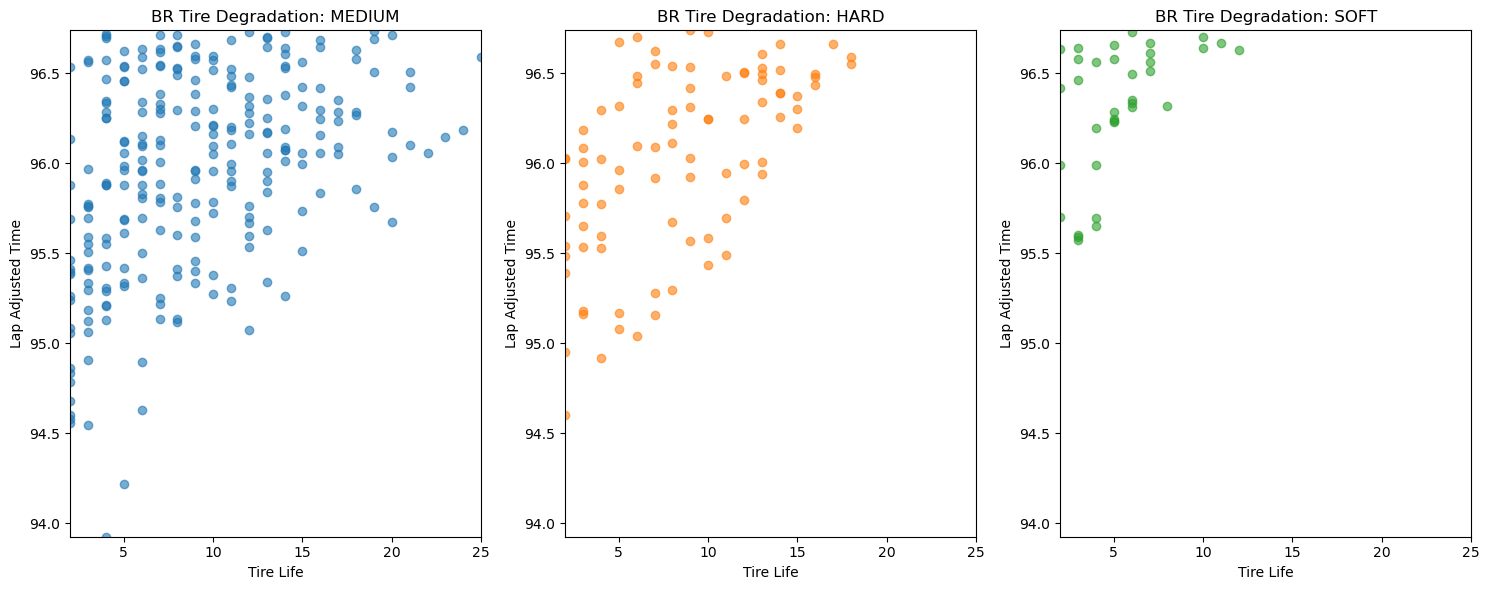

Training models for compounds: ['MEDIUM' 'HARD' 'SOFT']
Compound MEDIUM - Epoch 200, Loss: 0.2804
Compound MEDIUM - Epoch 400, Loss: 0.2395
Compound MEDIUM - Epoch 600, Loss: 0.2613
Compound MEDIUM - Epoch 800, Loss: 0.2403
Compound MEDIUM - Epoch 1000, Loss: 0.2440
Compound HARD - Epoch 200, Loss: 0.2275
Compound HARD - Epoch 400, Loss: 0.1757
Compound HARD - Epoch 600, Loss: 0.1757
Compound HARD - Epoch 800, Loss: 0.1944
Compound HARD - Epoch 1000, Loss: 0.1955
Compound SOFT - Epoch 200, Loss: 0.1009
Compound SOFT - Epoch 400, Loss: 0.0965
Compound SOFT - Epoch 600, Loss: 0.0965
Compound SOFT - Epoch 800, Loss: 0.0965
Compound SOFT - Epoch 1000, Loss: 0.0967


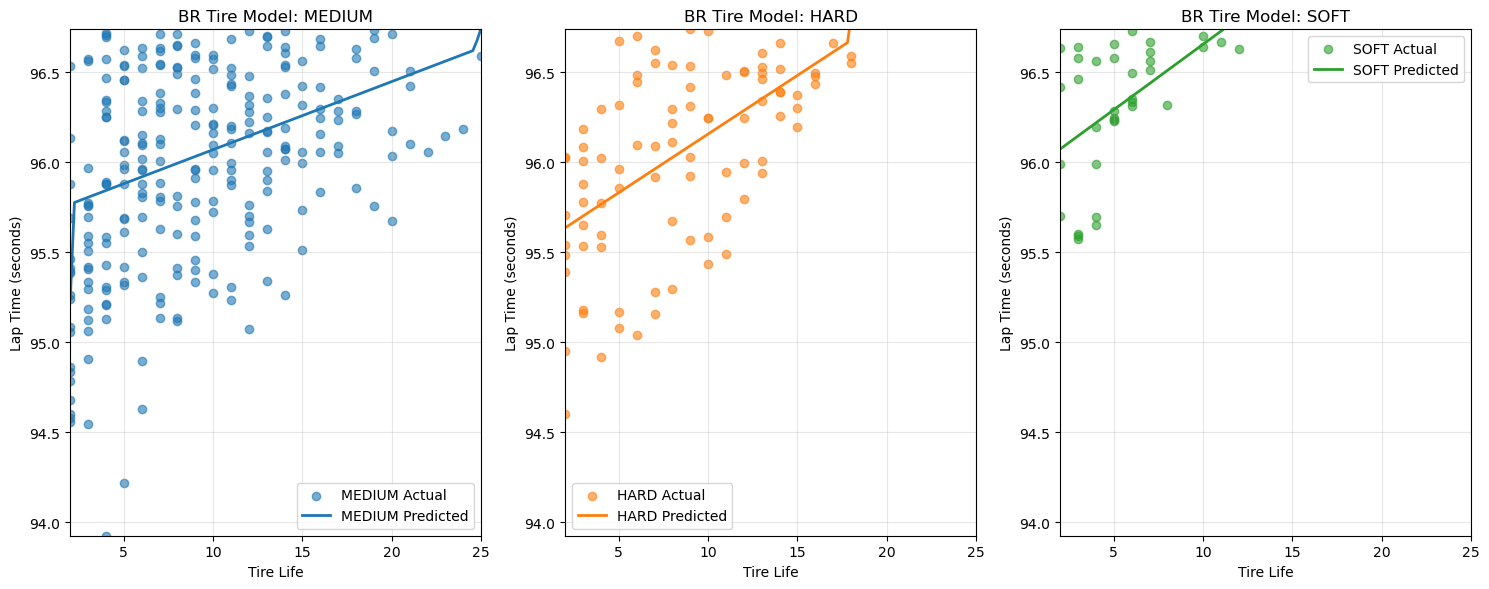

Using pit stop time penalty for BR: 25.27s

=== BR RACE STRATEGY OPTIMIZATION ===

Evaluating strategies with 0 pit stops...
  No stops with MEDIUM: 6539.92s (01:48:59.915)
  New best strategy found: 6539.92s (01:48:59.915)
  No stops with HARD: 8074.37s (02:14:34.368)
  No stops with SOFT: 8398.09s (02:19:58.092)

Evaluating strategies with 1 pit stops...
  Found better strategy: [30], ['MEDIUM', 'MEDIUM'], 5509.88s (01:31:49.884)
  New best strategy found: 5509.88s (01:31:49.884)

Evaluating strategies with 2 pit stops...
  Found better strategy: [20, 39], ['MEDIUM', 'MEDIUM', 'MEDIUM'], 5500.87s (01:31:40.868)
  New best strategy found: 5500.87s (01:31:40.868)

Evaluating strategies with 3 pit stops...
  Found better strategy: [15, 29, 43], ['MEDIUM', 'MEDIUM', 'MEDIUM', 'MEDIUM'], 5514.01s (01:31:54.005)

=== OPTIMAL STRATEGY FOR BR ===
Total race time: 5500.87 seconds (01:31:40.868)
Number of pit stops: 2
Pit stop laps: [20, 39]
Tire compounds: ['MEDIUM', 'MEDIUM', 'MEDIUM']

=== 

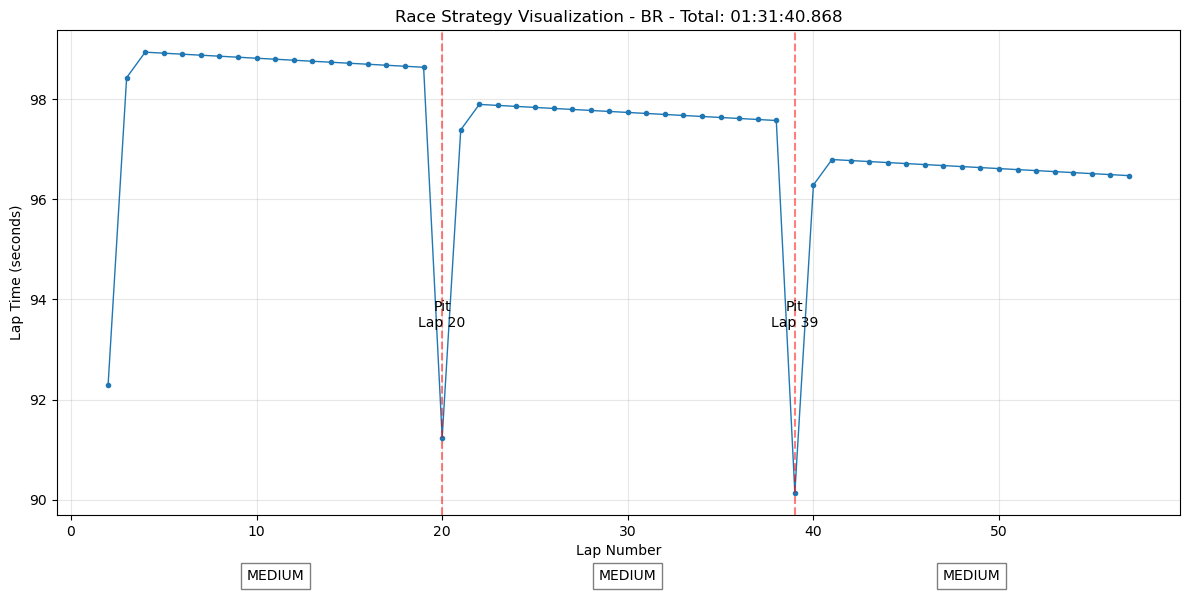

In [57]:
bahrain_result = optimize_strategy(brf, 57, 'br')

=== JR RACE STRATEGY OPTIMIZATION ===


<Figure size 1500x600 with 0 Axes>

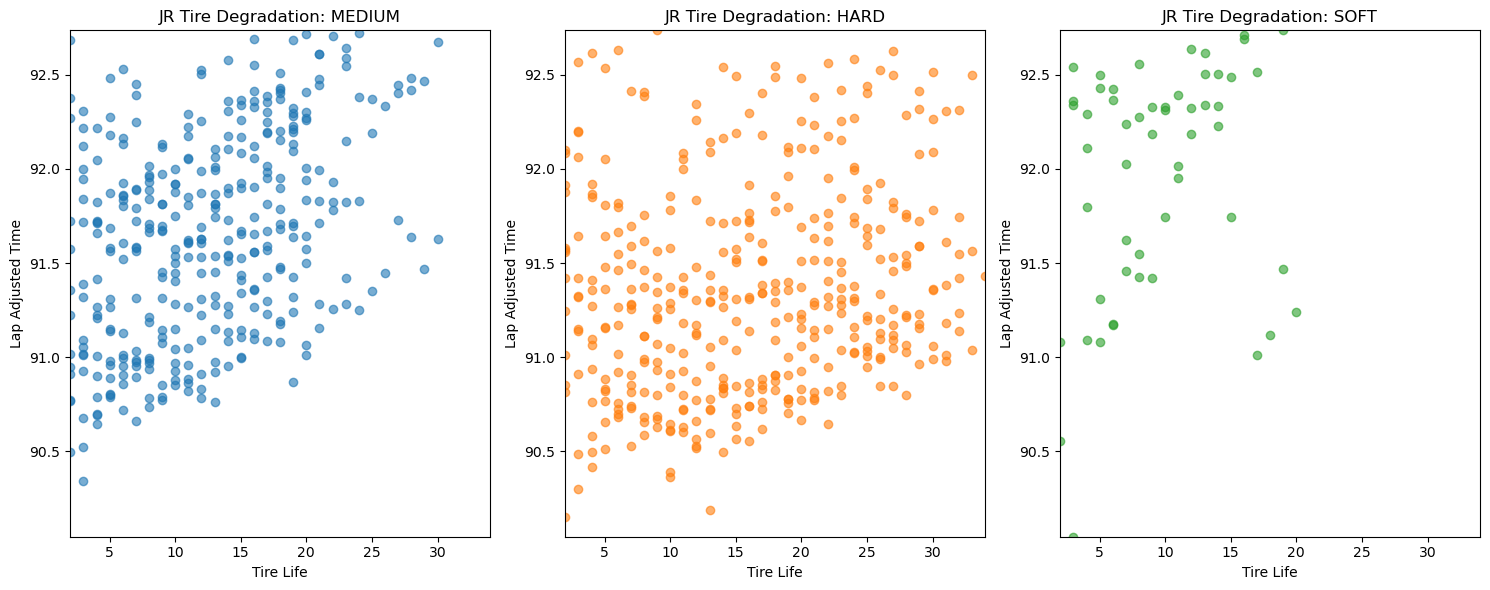

Training models for compounds: ['MEDIUM' 'HARD' 'SOFT']
Compound MEDIUM - Epoch 200, Loss: 1.0429
Compound MEDIUM - Epoch 400, Loss: 0.2609
Compound MEDIUM - Epoch 600, Loss: 0.6973
Compound MEDIUM - Epoch 800, Loss: 0.2494
Compound MEDIUM - Epoch 1000, Loss: 0.2478
Compound HARD - Epoch 200, Loss: 4.5269
Compound HARD - Epoch 400, Loss: 0.3092
Compound HARD - Epoch 600, Loss: 0.2911
Compound HARD - Epoch 800, Loss: 0.6758
Compound HARD - Epoch 1000, Loss: 0.2912
Compound SOFT - Epoch 200, Loss: 0.7762
Compound SOFT - Epoch 400, Loss: 0.3191
Compound SOFT - Epoch 600, Loss: 0.3177
Compound SOFT - Epoch 800, Loss: 0.3777
Compound SOFT - Epoch 1000, Loss: 0.3363


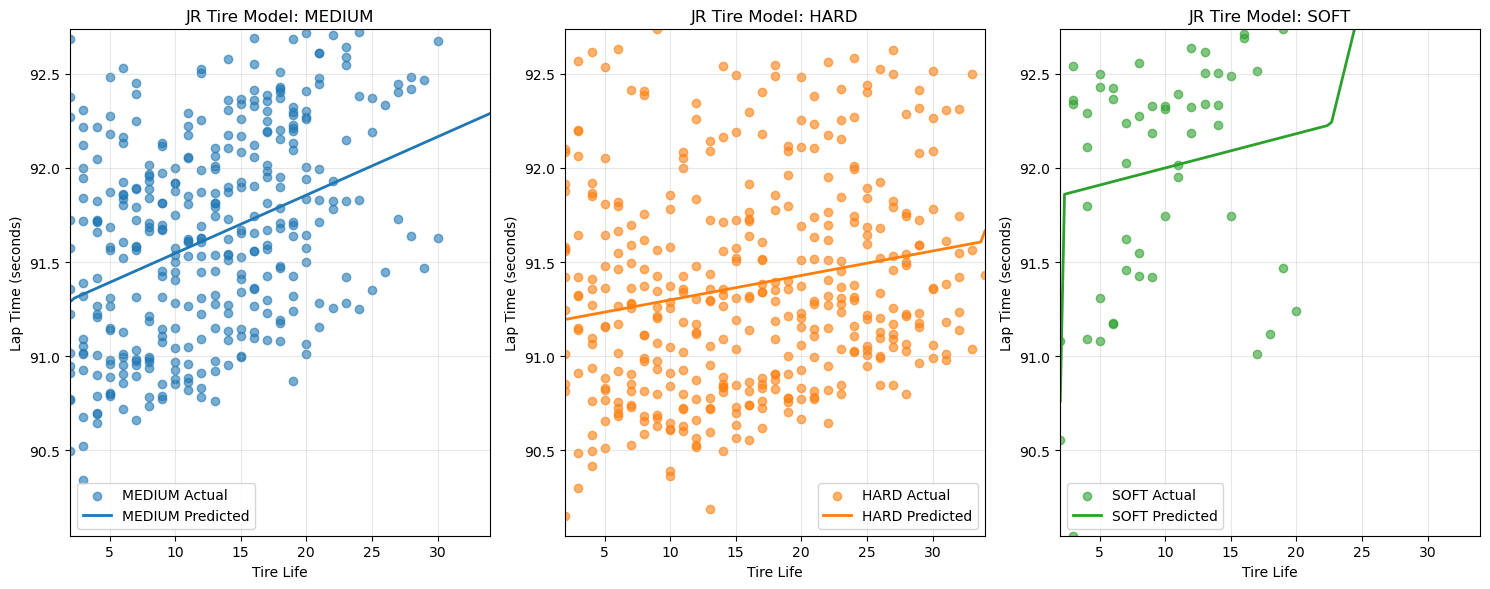

Using pit stop time penalty for JR: 23.81s

=== JR RACE STRATEGY OPTIMIZATION ===

Evaluating strategies with 0 pit stops...
  No stops with MEDIUM: 4578.87s (01:16:18.869)
  New best strategy found: 4578.87s (01:16:18.869)
  No stops with HARD: 4630.59s (01:17:10.593)
  No stops with SOFT: 4681.68s (01:18:01.683)

Evaluating strategies with 1 pit stops...
  Found better strategy: [26], ['MEDIUM', 'MEDIUM'], 4573.67s (01:16:13.669)
  Found better strategy: [17], ['MEDIUM', 'HARD'], 4566.00s (01:16:05.997)
  Found better strategy: [26], ['HARD', 'HARD'], 4564.07s (01:16:04.074)
  New best strategy found: 4564.07s (01:16:04.074)

Evaluating strategies with 2 pit stops...
  Found better strategy: [18, 34], ['MEDIUM', 'MEDIUM', 'MEDIUM'], 4580.84s (01:16:20.836)
  Found better strategy: [14, 24], ['MEDIUM', 'MEDIUM', 'HARD'], 4577.35s (01:16:17.352)
  Found better strategy: [11, 40], ['MEDIUM', 'HARD', 'MEDIUM'], 4577.28s (01:16:17.276)
  Found better strategy: [9, 30], ['MEDIUM', 'HARD', 

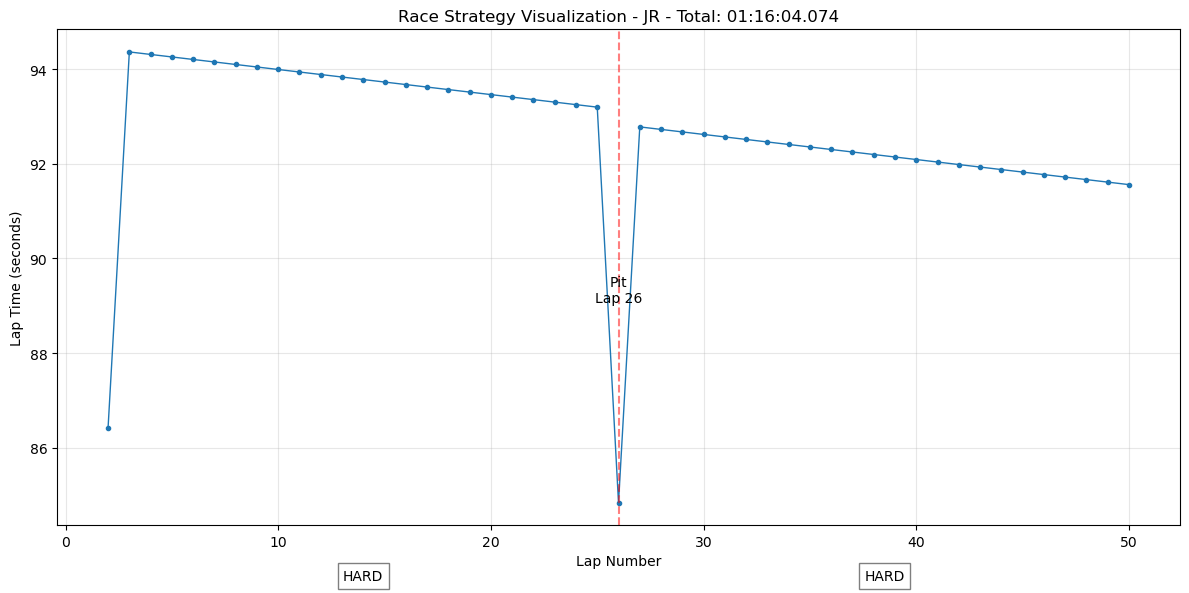

In [60]:
japan_result = optimize_strategy(jrf, 50, 'jr')

=== CR RACE STRATEGY OPTIMIZATION ===


<Figure size 1500x600 with 0 Axes>

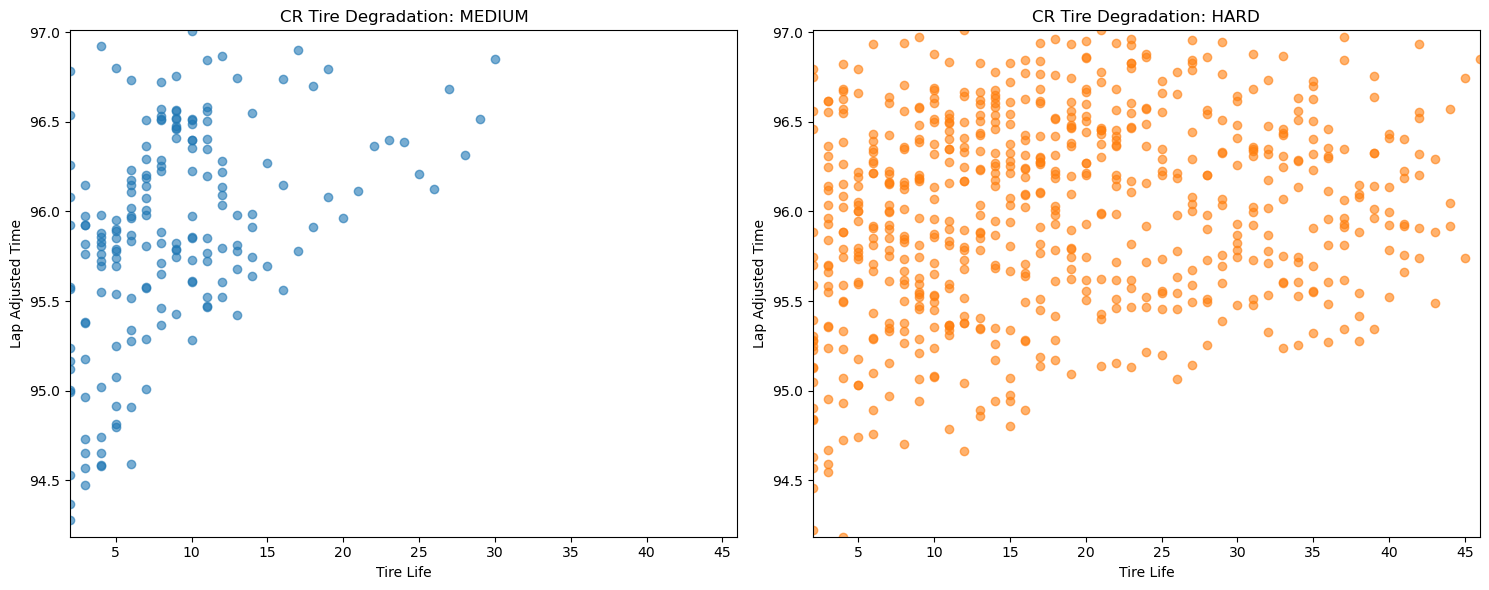

Training models for compounds: ['MEDIUM' 'HARD']
Compound MEDIUM - Epoch 200, Loss: 0.2807
Compound MEDIUM - Epoch 400, Loss: 0.2799
Compound MEDIUM - Epoch 600, Loss: 0.2916
Compound MEDIUM - Epoch 800, Loss: 0.2787
Compound MEDIUM - Epoch 1000, Loss: 0.2789
Compound HARD - Epoch 200, Loss: 0.3109
Compound HARD - Epoch 400, Loss: 0.2866
Compound HARD - Epoch 600, Loss: 0.2812
Compound HARD - Epoch 800, Loss: 0.2801
Compound HARD - Epoch 1000, Loss: 0.2809


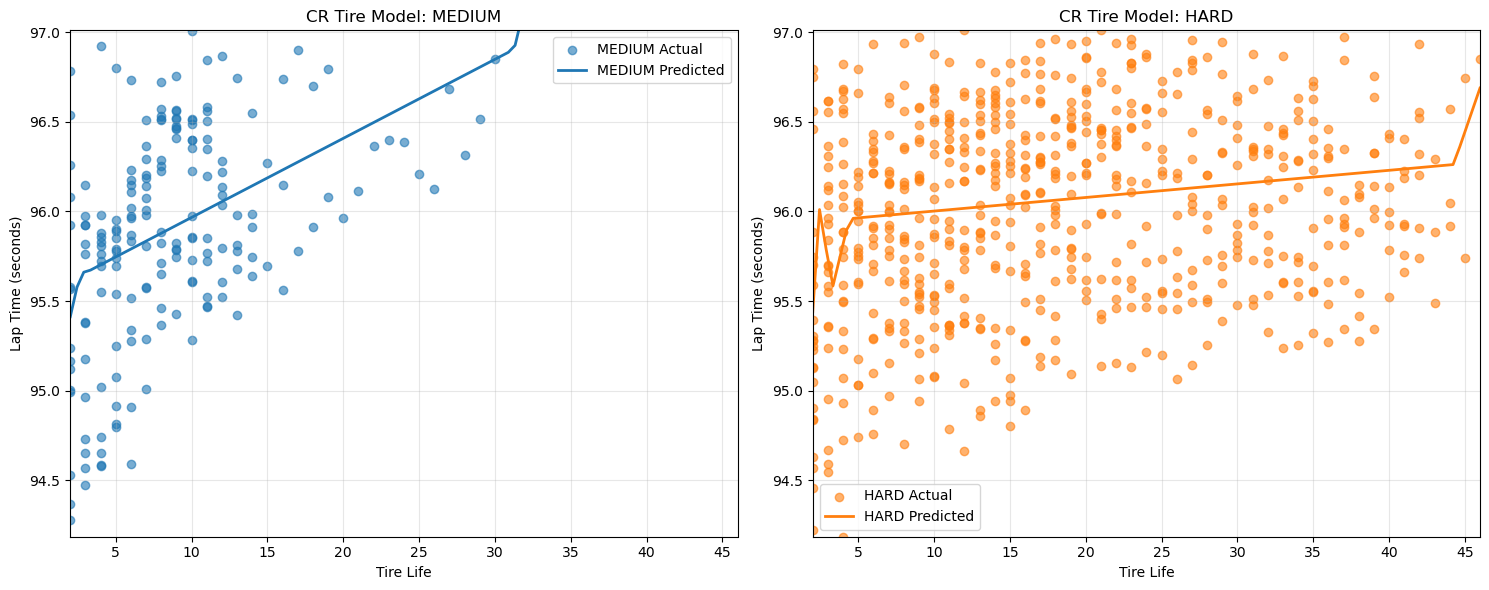

Using pit stop time penalty for CR: 23.35s

=== CR RACE STRATEGY OPTIMIZATION ===

Evaluating strategies with 0 pit stops...
  No stops with MEDIUM: 5645.62s (01:34:05.618)
  New best strategy found: 5645.62s (01:34:05.618)
  No stops with HARD: 5392.14s (01:29:52.140)
  New best strategy found: 5392.14s (01:29:52.140)

Evaluating strategies with 1 pit stops...
  Found better strategy: [29], ['MEDIUM', 'MEDIUM'], 5395.39s (01:29:55.389)
  Found better strategy: [19], ['MEDIUM', 'HARD'], 5386.22s (01:29:46.216)
  Found better strategy: [29], ['HARD', 'HARD'], 5384.42s (01:29:44.419)
  New best strategy found: 5384.42s (01:29:44.419)

Evaluating strategies with 2 pit stops...
  Found better strategy: [20, 38], ['MEDIUM', 'MEDIUM', 'MEDIUM'], 5404.03s (01:30:04.030)
  Found better strategy: [16, 29], ['MEDIUM', 'MEDIUM', 'HARD'], 5401.32s (01:30:01.320)
  Found better strategy: [14, 36], ['MEDIUM', 'HARD', 'HARD'], 5400.53s (01:30:00.531)
  Found better strategy: [20, 38], ['HARD', 'HARD'

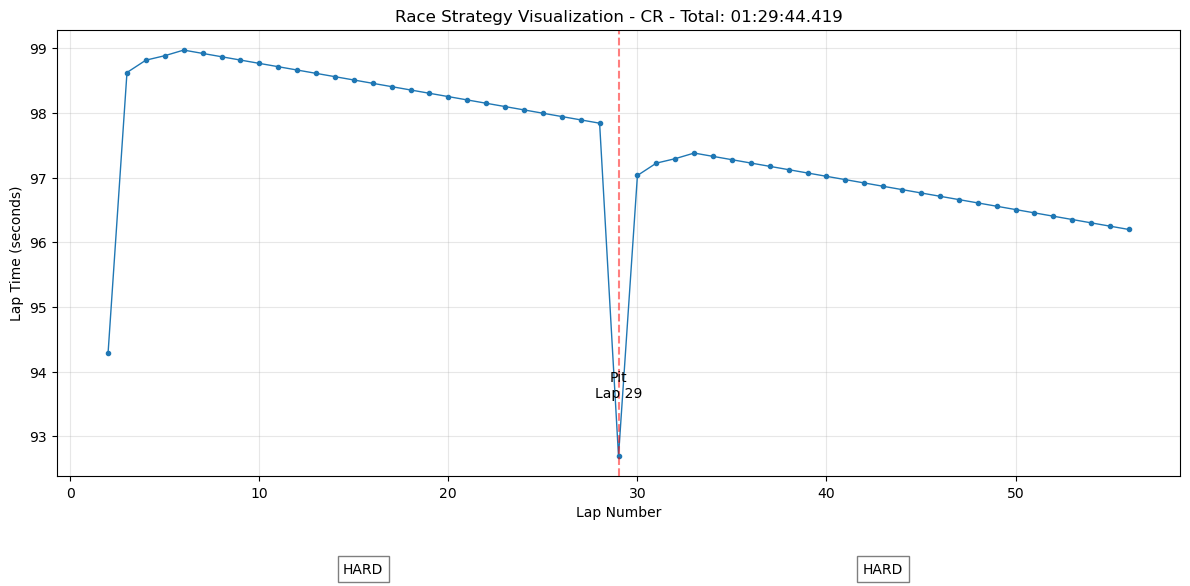

In [61]:
china_result = optimize_strategy(crf, 56, 'cr')

I believe these spikes that are being seen are due to the fact that the data actually does not include the actual lap time for the lap immediately follow the pit stop, as it is technically a shorter lap due to the location of the pit lane. I was not able to figure out a good solution to this, so I will leave the model as is. Since every strategy has this issue, it should not siginificantly benefit one strategy over another.

## Simulation Analysis

### Bahrain

Winner: Oscar Piastri\
Time: 1:35:39.435\
Pit stops: Laps 14 and 32\
Tires used: Soft, Medium, Medium

The model had a similar tire and pit strategy, but instead it found that medium tires for the whole race and wanted to pit slightly later. The simulated race time was also about 4 minutes faster than the actual winning time.

### Japan

Winner: Max Verstappen\
Time: 1:22:06.983\
Pit stops: Lap 21\
Tires used: Medium, Hard


The model and the actual winner both only used 1 pit stop, however different tires were used. Max Verstappen used medium tires and then hard tires, however the model found that using hard tires the whole time would be best. The model also pits a few laps later than in the actual race. The difference his winning time and the simulated time is about 6 minutes.

### China

Winner: Oscar Piastri\
Time: 1:30:55.026\
Pit stops: Lap 14\
Tires used: Medium, Hard


For this race the model wants to use the Japan strategy of double hard tires and has about a 1 minute difference to the actual winning time and our found fastest time. This is the smallest difference between the model time and the actual time.

The biggest reason for the model being faster than the actual race times is that the model does not need to deal with external factors. These are the best laps drivers are putting up, with no safety cars, little human error, and unlimited tire supply. I am not quite sure why the time for China is so close to the actual winning time, it could be that there is less data for the mediums, so the model thinks they degrade faster than they might actually be degrading. The model also always wants to pit later than the winning drivers in actual races, and I think this is because the model does not need to worry about pit lane traffic. When pitting at common times, the car may be held up for a few extra seconds in order to avoid collisions, and after rejoining the race may find itself stuck inbetween other slower cars, thus slowing it down significantly. As such, winning drivers often pit earlier than normal in order to avoid this traffic, but it is a delicate balancing act.

# Future Work

### Weather Analysis

As evident from the different degradation graphs from the different races, weather and climate play an important role in determining how quickly tires will wear down. As such, I am interested in using weather data to estimate lap times, but I ran into many issues that I wasn't sure how to resolve.

For example: each of these tracks has different surfaces, and this also affects the wear on the tires. I found it to be nigh impossible to separate out how much the track surface affects tire wear. Furthermore, I cannot directly compare lap time, as each of these tracks is also a different length. I could try to calculate average speed, but some tracks will just be slower due to how they are designed. For example, tracks with many sharp corners will be slower than tracks with long straights and high speed corners, so this would also affect the average speed significantly, perhaps even more so than weather. In addition, the tire compounds change from year to year and even race to race (the "medium" one weekend could be designated the "soft" the next weekend), making comparisons between 2023, 2024, and 2025 races on the same circuit also very difficult to perform.

If Professor Coleman could give me some insight as to how one might deal with these factors, I would greatly appreciate it.